<div style="position: relative;">
<img src="https://user-images.githubusercontent.com/7065401/98728503-5ab82f80-2378-11eb-9c79-adeb308fc647.png"></img>

<h1 style="color: white; position: absolute; top:27%; left:10%;">
     Software Development with Python
</h1>

<h3 style="color: #ef7d22; font-weight: normal; position: absolute; top:55%; left:10%;">
    David Mertz, Ph.D.
</h3>

<h3 style="color: #ef7d22; font-weight: normal; position: absolute; top:62%; left:10%;">
    Data Scientist
</h3>
</div>

# Timing execution



I nice saying in software development is:

> Make it work, make it right, make it fast (in order)

Assuming you have spent plenty of time in the debugger, the time might be right to speed up your code.

Naively, it might seem like you can time operations simply by measuring the time before they start, and the time after they are done.  This is not entirely wrong, at a coarse level.  But the background activity of your computer can vary, including internal garbage collection by Python itself, cache hits vs. misses, disk seek times varying, and so on.  These "accidents" can cause signficant variation in behavior.

## Starting naively

Let us try a naive approach to the relatively slow `mandelbrot()` function.

In [1]:
import time 
# most accurate timer; undefined zero point
time.perf_counter_ns() 

2896820282148287

In [2]:
# Resolution (in seconds) of best clock
time.clock_getres(time.CLOCK_MONOTONIC_RAW) 

1e-09

In [3]:
import sys
sys.path.append('../Fractal')
from fractal.mandelbrot import mandelbrot
from fractal.visualize import make_canvas

In [4]:
start = time.perf_counter_ns()
canvas = make_canvas(mandelbrot, -1.0, 0.28, 0.15, 800)
end = time.perf_counter_ns()
print(f"Generating sample Mandelbrot fractal took {(end-start)/1e9:.3f} seconds")

Generating sample Mandelbrot fractal took 15.327 seconds


## Becoming consistent

The simple approach is fine for many tasks.  However, for sensitive inner loop operations we would like to be more consistent.  Moreover, sometimes we would like to exclude setup times to measure only the operation we are timing.  The `timeit` module is statistically sophisticated.  It reports outliers in time taken, and has modes where it can run "as many times as needed to get a good quality meausement."  Python garbage collection is disabled while `timeit` is sampling times.

There are several ways of using `timeit`. We can use it from the command line. We can use it as a regular module.  Or we can use it as an IPython "magic" within Jupyter.  Let us try the command line approach first, which is probably what you will use the most in software development.   We do not with to include the time to import the functions used, which we saw in the last lesson sometimes is a noticeable amount of time.  This example only shows the time for the function call itself.

In [5]:
%%time
%%bash
PYTHONPATH="../Fractal"
SETUP='from fractal.mandelbrot import mandelbrot; from fractal.visualize import make_canvas'
python -m timeit --setup "$SETUP" "make_canvas(mandelbrot, -1.0, 0.28, 0.15, 800)"

1 loop, best of 5: 12.6 sec per loop
CPU times: user 8.47 ms, sys: 4.03 ms, total: 12.5 ms
Wall time: 1min 39s


Within Jupyter I used the `%%time` magic along with `%%bash` to find out how much actual wall clock time was involved.

## Jupyter magic

While Jupyter is unlikely to be the primary place you develop your software project code, its `%%timeit` "magic" is extremely good.  It will dynamically adjust the number of loops and you can use either the line magic `%timeit` or the cell magic `%timeit`.

Let us run some very fast code then some (artificially) slow code to demonstrate.

In [6]:
%%timeit
# artificially slow code block
for i in range(100):
    for j in range(i):
        time.sleep(0.0002)

1.39 s ± 16.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
# Very fast code line
%timeit [i+i for i in range(500)]

44.1 µs ± 1.66 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


You can pass in extra switches `-r` and `-n` to manually configure runs and loops.  For statistical reasons, `%timeit` usually performs 7 separate runs of looping through the timed code N times.  The standard deviation is based on the aggregation of the runs rather than the individual code operation times.

## Timing alternative implementations

I have actually created alternative implementations of the `julia()` and `mandelbrot()` functions, called `fast_julia()` and `fast_mandelbrot()`.  I did not myself do anything terribly clever in finding faster implementations, but simply utilized the Just-in-Time compiler Numba.

You are welcome to look at the very simple code, but for this purpose, it only matters that two implementations *exist*.  We could compare them, for example, using different arguments.  

In this example, I expect the speedup to be fairly uniform; in more interesting real-world cases, it might be that one implementation is faster for some situations (e.g. some data sets in parameters), but the other implementation is faster in other cases.  These are tradeoffs you have to weigh in your software development.

In [8]:
from fractal.julia import julia, fast_julia
from fractal.mandelbrot import mandelbrot, fast_mandelbrot
from fractal.visualize import make_canvas, visualize

In [9]:
print("Non-optimized Mandelbrot at moderate zoom")
%timeit make_canvas(mandelbrot, -1.0, 0.28, 0.15, 800)
print("Optimized Mandelbrot at moderate zoom")
%timeit make_canvas(fast_mandelbrot, -1.0, 0.28, 0.15, 800)

Non-optimized Mandelbrot at moderate zoom
13.8 s ± 3.45 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
Optimized Mandelbrot at moderate zoom
1.52 s ± 12.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
m1 = make_canvas(mandelbrot, -1.0, 0.28, 0.15, 800)
m2 = make_canvas(fast_mandelbrot, -1.0, 0.28, 0.15, 800)
assert (m1 == m2).all()

In [11]:
print("Non-optimized Mandelbrot full set")
%timeit make_canvas(mandelbrot, 0, 0, 4, 800)
print("Optimized Mandelbrot full set")
%timeit make_canvas(fast_mandelbrot, 0, 0, 4, 800)

Non-optimized Mandelbrot full set
5.63 s ± 176 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Optimized Mandelbrot full set
1.45 s ± 72.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Since we are generating fractals, let us display it for its visual appeal.

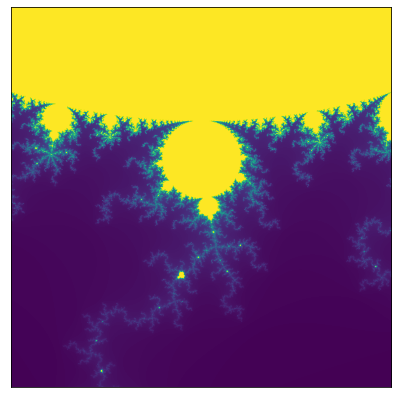

In [12]:
visualize(m1)

In [13]:
print("Non-optimized Julia at moderate zoom")
%timeit make_canvas(julia, -0.6, 0.20, 0.15, 800)
print("Optimized Julia at moderate zoom")
%timeit make_canvas(fast_julia, -0.6, 0.20, 0.15, 800)

Non-optimized Julia at moderate zoom
11.6 s ± 268 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Optimized Julia at moderate zoom
1.66 s ± 12 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


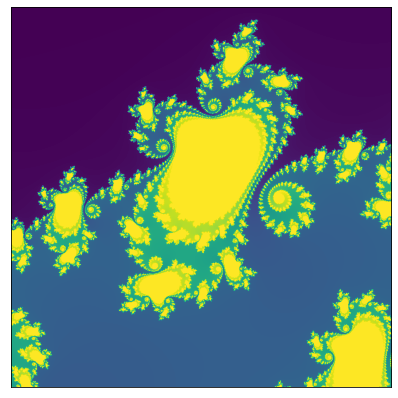

In [14]:
visualize(make_canvas(fast_julia, -0.6, 0.20, 0.15, 800))

## Timing from Python code

We can also, of course, use the `timeit` module programmatically.  There is a convenience function `timeit.timeit()` which can do a basic test.  Unfortunately, that simplest wrapper lacks the *autorange* functionality to dynamically adjust number of loops based on the time loops take.  Using the underlying class is not too difficult though.

In [17]:
import timeit
def timeit_autorange(statement, repeats=5):
    # create the timer
    timer = timeit.Timer(stmt=statement, globals=globals())
    # find the number of loops
    loops = timer.autorange()[0]
    # execute the timeit
    times = timer.repeat(repeats, loops)
    print(f"{loops} loops in each repetition")
    results = ", ".join(f"{s:.2f}" for s in times)
    print("Loop times (seconds):", results)

In [18]:
statement = "make_canvas(fast_julia, -0.6, 0.20, 0.15, 800)"
timeit_autorange(statement)

1 loops in each repetition
Loop times (seconds): 2.26, 2.19, 2.39, 2.02, 2.43


In [19]:
timeit_autorange("x = (1+2)*3")

10000000 loops in each repetition
Loop times (seconds): 0.30, 0.20, 0.23, 0.23, 0.22
